In [1]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=24f5eda534ee4e2466944ae2d95153929ff4386ab5085852c8f6852bbe196f3d
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=d162696ae0cdb93c7e54f4963584316d5060c4f6db854456738bc500c8ff7ac3
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [2]:
from tqdm import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/MultiSportsFootball.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [5]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [6]:
class CONFIG:
  epochs = 10
  batch_size = 8
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  learning_rate = 1e-4
  num_workers = 2
  classes = ['football short pass', 'football dribble', 'football diving', 'football throw']
  videos_per_class = 50

In [7]:
class2label = {class_name: i for i, class_name in enumerate(CONFIG.classes)}
label2class = {i: class_name for i, class_name in enumerate(CONFIG.classes)}

In [8]:
def get_files_and_class_names(path, num_classes=None):
    video_paths = list(path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]

    path_per_class = collections.defaultdict(list)
    for p, c in zip(video_paths, classes):
        if c in CONFIG.classes:
          path_per_class[c].append(p)

    video_paths = []
    classes = []
    for c, paths in path_per_class.items():
        if num_classes is not None:
          num_class_examples = min(len(paths), num_classes)
        else:
          num_class_examples = len(paths)
        paths = np.array(paths)
        indexes = np.linspace(0, len(paths) - 1, num_class_examples, dtype=int)
        class_paths = paths[indexes].tolist()
        video_paths.extend(class_paths)
        classes.extend([class2label[c] for _ in range(len(class_paths))])

    return video_paths, classes

In [9]:
# Custom Dataset class
class VideoDataset(Dataset):
    def __init__(self, file_paths, targets, transform=None):
        self.file_paths = file_paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        video_frames = frames_from_video_file(self.file_paths[idx],
                                              n_frames=16, frame_step=4)
        video_frames = torch.FloatTensor(video_frames)

        if self.transform:
          video_frames = torch.transpose(video_frames, 0, 1)
          video_frames = self.transform(video_frames)
          video_frames = torch.transpose(video_frames, 0, 1)

        label = self.targets[idx]

        return video_frames, torch.tensor(label, dtype=torch.long)

def format_frames(frame, output_size):
    """Format frames to tensor with specified size"""
    frame = cv2.resize(frame, output_size)
    frame = frame / 255.0
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=4):
    """Extract frames from video file"""
    result = []
    src = cv2.VideoCapture(str(video_path))

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))

    src.release()

    result = np.array(result)
    result = np.transpose(result, (3, 0, 1, 2))  # (T, C, H, W) format
    return result

In [10]:
# Model definition
class VideoClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VideoClassifier, self).__init__()
        self.model = torch.hub.load('facebookresearch/hiera', model='hiera_base_plus_16x224', pretrained=True)
        proj = self.model.head.projection
        self.model.head.projection = nn.Linear(proj.in_features, num_classes)

        # Freeze the pre-trained parameters
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.blocks[4:].parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.model(x)

        return x


In [11]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for video, labels in tqdm(dataloader):
        video, labels = video.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(video)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for video, labels in tqdm(dataloader):
            video, labels = video.to(device), labels.to(device)

            outputs = model(video)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc, all_preds, all_labels

In [12]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [13]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history['train_loss'], label = 'train')
  ax1.plot(history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history['train_loss'] + history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history['train_acc'],  label = 'train')
  ax2.plot(history['val_acc'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 100])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

In [14]:
# Load dataset
train_paths, train_classes = get_files_and_class_names(pathlib.Path('./train'))
val_paths, val_classes = get_files_and_class_names(pathlib.Path('./valid'))

# Create datasets and dataloaders

train_dataset = VideoDataset(train_paths, train_classes)
val_dataset = VideoDataset(val_paths, val_classes)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG.batch_size,
    shuffle=True,
    num_workers=CONFIG.num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG.batch_size,
    shuffle=False,
    num_workers=CONFIG.num_workers
)

In [15]:
# Main training loop
def main(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.5
    )

    # Training loop
    best_val_acc = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(CONFIG.epochs):
        print(f'Epoch {epoch+1}/{CONFIG.epochs}')

        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, CONFIG.device
        )

        val_loss, val_acc, all_preds, all_labels = validate(
            model, val_loader, criterion, CONFIG.device
        )

        # Update learning rate
        scheduler.step(val_loss)


        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint_path = 'best.pt'

            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            }, checkpoint_path)

        torch.save({
          'epoch': epoch + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          }, 'last.pt')

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    return history

In [16]:
# Initialize model
model = VideoClassifier(num_classes=len(CONFIG.classes)).to(CONFIG.device)

Downloading: "https://github.com/facebookresearch/hiera/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Downloading: "https://dl.fbaipublicfiles.com/hiera/hiera_base_plus_16x224.pth" to /root/.cache/torch/hub/checkpoints/hiera_base_plus_16x224.pth
100%|██████████| 794M/794M [00:19<00:00, 43.7MB/s]


In [17]:
history = main(model)

Epoch 1/10


100%|██████████| 106/106 [00:30<00:00,  3.43it/s]


Train Loss: 0.4095 Train Acc: 88.07%
Val Loss: 0.8671 Val Acc: 92.28%
Epoch 2/10


100%|██████████| 106/106 [00:30<00:00,  3.44it/s]


Train Loss: 0.3198 Train Acc: 90.72%
Val Loss: 0.8478 Val Acc: 91.69%
Epoch 3/10


100%|██████████| 106/106 [00:30<00:00,  3.45it/s]


Train Loss: 0.2592 Train Acc: 92.34%
Val Loss: 0.8400 Val Acc: 92.87%
Epoch 4/10


100%|██████████| 106/106 [00:30<00:00,  3.43it/s]


Train Loss: 0.2244 Train Acc: 93.37%
Val Loss: 0.8479 Val Acc: 93.59%
Epoch 5/10


100%|██████████| 106/106 [00:30<00:00,  3.45it/s]


Train Loss: 0.1970 Train Acc: 94.12%
Val Loss: 0.8299 Val Acc: 95.25%
Epoch 6/10


100%|██████████| 106/106 [00:30<00:00,  3.44it/s]


Train Loss: 0.1748 Train Acc: 94.62%
Val Loss: 0.8333 Val Acc: 93.71%
Epoch 7/10


100%|██████████| 106/106 [00:30<00:00,  3.42it/s]


Train Loss: 0.1432 Train Acc: 95.16%
Val Loss: 0.8340 Val Acc: 92.76%
Epoch 8/10


100%|██████████| 106/106 [00:30<00:00,  3.45it/s]


Train Loss: 0.1210 Train Acc: 95.90%
Val Loss: 0.8997 Val Acc: 86.70%
Epoch 9/10


100%|██████████| 106/106 [00:30<00:00,  3.43it/s]


Train Loss: 0.1034 Train Acc: 96.48%
Val Loss: 0.8199 Val Acc: 94.18%
Epoch 10/10


100%|██████████| 106/106 [00:30<00:00,  3.43it/s]


Train Loss: 0.1061 Train Acc: 96.73%
Val Loss: 0.8209 Val Acc: 93.47%


In [18]:
model.load_state_dict(torch.load('best.pt', weights_only=True, map_location=CONFIG.device)['model_state_dict'])

<All keys matched successfully>

100%|██████████| 106/106 [00:30<00:00,  3.43it/s]


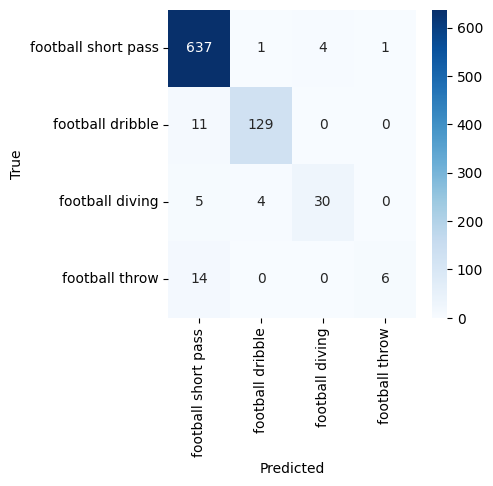

In [19]:
criterion = nn.CrossEntropyLoss()

val_loss, val_acc, all_preds, all_labels = validate(
  model, val_loader, criterion, CONFIG.device
)

plot_confusion_matrix(all_labels, all_preds, CONFIG.classes)

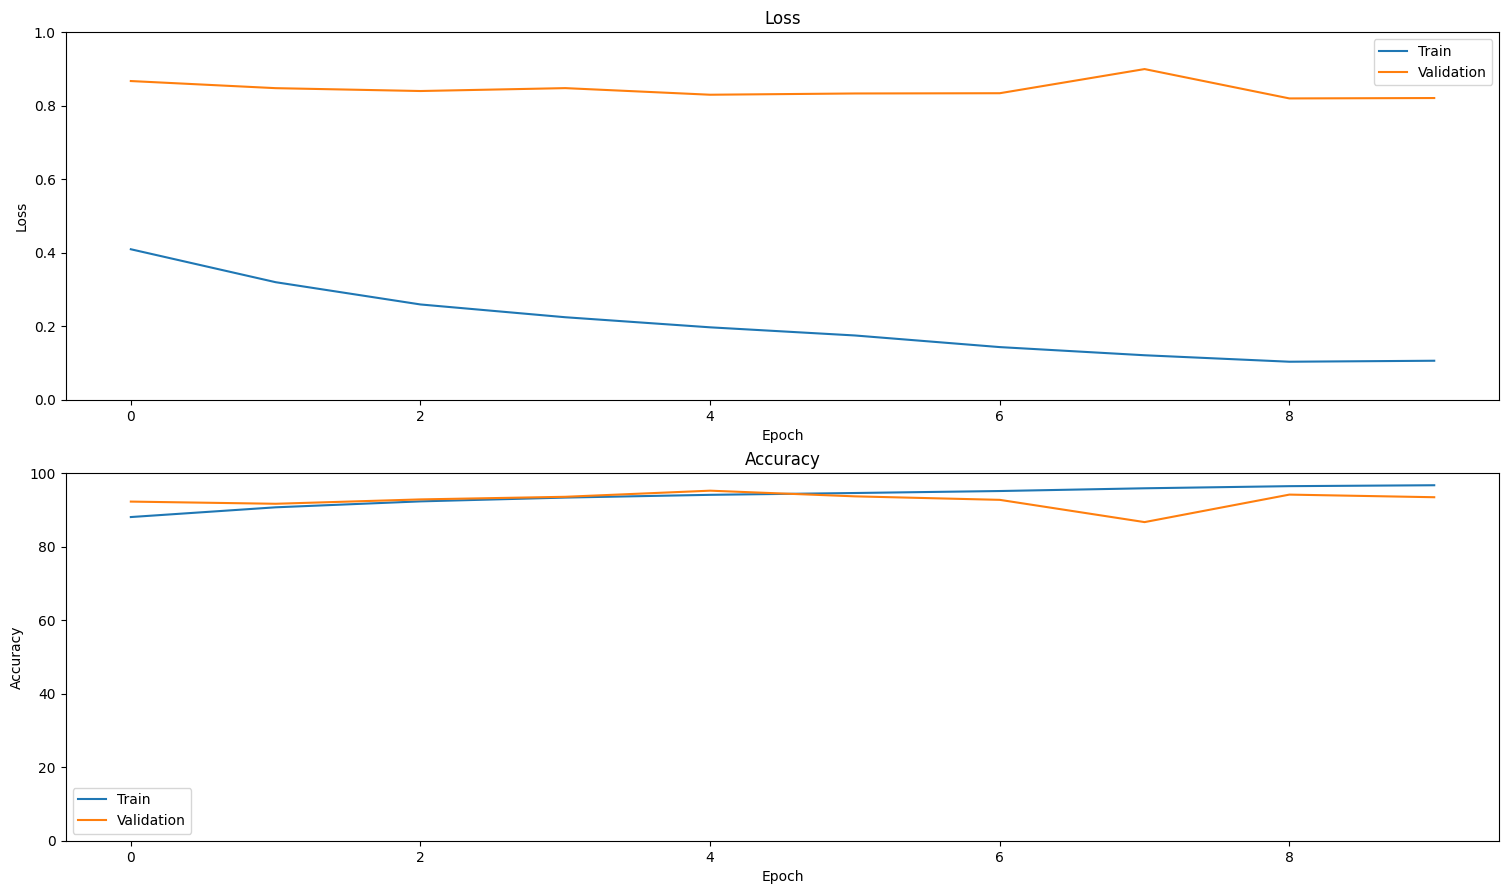

In [20]:
plot_history(history)

In [21]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  f1 = dict()

  macroF1 = 0
  macroP = 0
  macroR = 0

  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    if (tp[i] + fp) == 0:
      precision[labels[i]] = 0
    else:
      precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    if (tp[i] + fn) == 0:
      recall[labels[i]] = 0
    else:
      recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

    if (precision[labels[i]] + recall[labels[i]]) == 0:
      f1[labels[i]] = 0
    else:
      f1[labels[i]] = 2 * (precision[labels[i]] * recall[labels[i]]) / (precision[labels[i]] + recall[labels[i]])

    macroF1 += f1[labels[i]]
    macroP += precision[labels[i]]
    macroR += recall[labels[i]]

  return precision, recall, f1, macroF1/len(labels), macroP/len(labels), macroR/len(labels)

In [22]:
precision, recall, f1, macroF1, macroP, macroR = calculate_classification_metrics(all_labels, all_preds, CONFIG.classes)

In [23]:
precision

{'football short pass': np.float64(0.9550224887556222),
 'football dribble': np.float64(0.9626865671641791),
 'football diving': np.float64(0.8823529411764706),
 'football throw': np.float64(0.8571428571428571)}

In [24]:
recall

{'football short pass': np.float64(0.9906687402799378),
 'football dribble': np.float64(0.9214285714285714),
 'football diving': np.float64(0.7692307692307693),
 'football throw': np.float64(0.3)}

In [25]:
f1

{'football short pass': np.float64(0.9725190839694657),
 'football dribble': np.float64(0.9416058394160584),
 'football diving': np.float64(0.8219178082191781),
 'football throw': np.float64(0.4444444444444444)}

In [26]:
print(f'Macro F1: {macroF1:.4f}')
print(f'Macro Precision: {macroP:.4f}')
print(f'Macro Recall: {macroR:.4f}')

Macro F1: 0.7951
Macro Precision: 0.9143
Macro Recall: 0.7453
